# Comparing mass profiles of MN profile with actual disk

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modules import potential_tools as pt
from astropy.table import Table
from matplotlib.colors import LogNorm
import getdist as getdist
from getdist import MCSamples
import copy
import time
import matplotlib as mpl

In [2]:
mpl.rcParams['axes.labelsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'xx-large'
mpl.rcParams['ytick.labelsize'] = 'xx-large'

## Reading the phase space of isolated LMC disk

In [3]:
iso_phase = Table.read('./data/LMC_iso_rotated_phase_space.fits')

x, y, z = iso_phase['u'], iso_phase['v'], iso_phase['w']
pos = np.array([x, y, z])

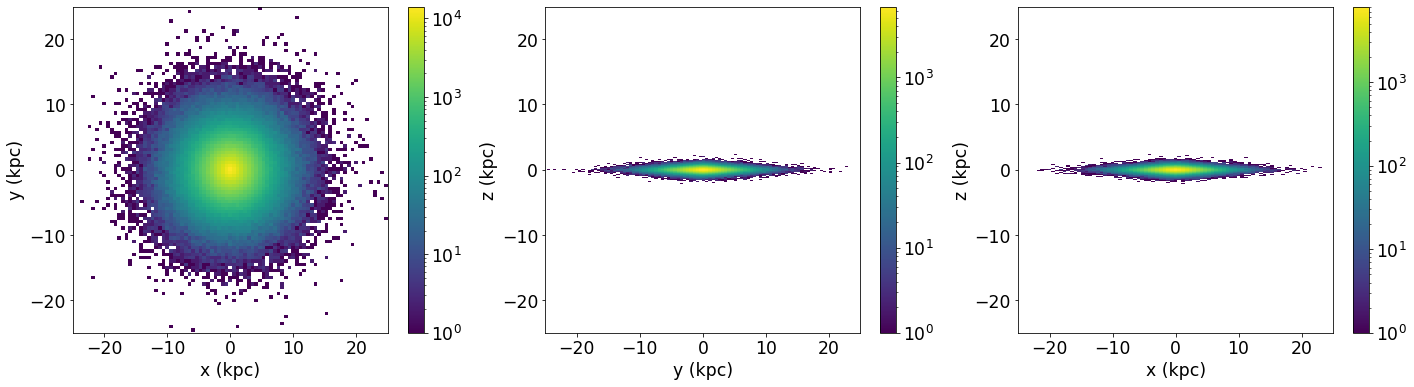

In [4]:
fig = plt.figure(figsize = (24,6))

ax1 = plt.subplot(1,3,1)
h1, xedg1, yedg1, im1 = ax1.hist2d(x, y, bins = 100, norm = LogNorm())
ax1.set_xlabel('x (kpc)')
ax1.set_ylabel('y (kpc)')
ax1.set_xlim(-25, 25)
ax1.set_ylim(-25, 25)
fig.colorbar(mappable = im1, ax = ax1)

ax2 = plt.subplot(1,3,2)
h2, xedg2, yedg2, im2 = ax2.hist2d(y, z, bins = 100, norm = LogNorm())
ax2.set_xlabel('y (kpc)')
ax2.set_ylabel('z (kpc)')
ax2.set_xlim(-25, 25)
ax2.set_ylim(-25, 25)
fig.colorbar(mappable = im2, ax = ax2)

ax3 = plt.subplot(1,3,3)
h3, xedg3, yedg3, im3 = ax3.hist2d(x, z, bins = 100, norm = LogNorm())
ax3.set_xlabel('x (kpc)')
ax3.set_ylabel('z (kpc)')
ax3.set_xlim(-25, 25)
ax3.set_ylim(-25, 25)
fig.colorbar(mappable = im3, ax = ax3)

plt.show()

In [5]:
#MCMC chains for MN fit and initializing getdist MCSamples object

samples = np.loadtxt('./chains/mcmc_MN_profile.txt')[-100:, :]
Nsamples = len(samples)
getdist_samples = MCSamples(samples = samples, names = ['a', 'b', 'logM'], labels = ['a', 'b', 'logM'])

Removed no burn in


## Radial mass profile

### Defining the radial cylinders

In [6]:
Ri = 0
Rf = np.arange(0.5, 20.5, 0.5)
zi, zf = 0, 2

### Mass profile of the actual disk

In [8]:
mstar = 2500 #mass of a star particle

In [9]:
rad_mass_profile_actual = np.array([])
rad_mass_profile_actual_error = np.array([])
for Rfs in Rf:
    counts = pt.get_counts_cylinder(pos, Ri, Rfs, zi, zf)
    rad_mass_profile_actual = np.append(rad_mass_profile_actual, mstar*counts)
    rad_mass_profile_actual_error = np.append(rad_mass_profile_actual_error, mstar*np.sqrt(counts))

### Mass profile of the MN model

In [10]:
getdist_samples_rad = copy.deepcopy(getdist_samples)

In [11]:
start = time.time()

for Rfs in Rf:
    
    rad_mass_profile_MN = np.array([])
    
    for chain_idx in range(Nsamples):
        
        a = getdist_samples_rad['a'][chain_idx]
        b = getdist_samples_rad['b'][chain_idx]
        logM = getdist_samples_rad['logM'][chain_idx]
        
        rad_mass_profile_MN = np.append(rad_mass_profile_MN,
                                        pt.MN_mass(Ri, Rfs, zi, zf, a, b, logM))
        
    getdist_samples_rad.addDerived(rad_mass_profile_MN, name = 'MN_mass_rad'+ str(Rfs))
    
end = time.time()

In [12]:
print(end - start)

83.81409859657288


In [13]:
mean_rad_mass_profile_MN = getdist_samples_rad.getMeans()[3:]
std_rad_mass_profile_MN = np.sqrt(getdist_samples_rad.getVars()[3:])

In [14]:
log_radial_res, log_radial_res_error = pt.get_fit_residual(np.log10(rad_mass_profile_actual), 
                                                           np.log10(mean_rad_mass_profile_MN),
                                                          rad_mass_profile_actual_error/(np.log(10)*rad_mass_profile_actual),
                                                          std_rad_mass_profile_MN/(np.log(10)*mean_rad_mass_profile_MN))

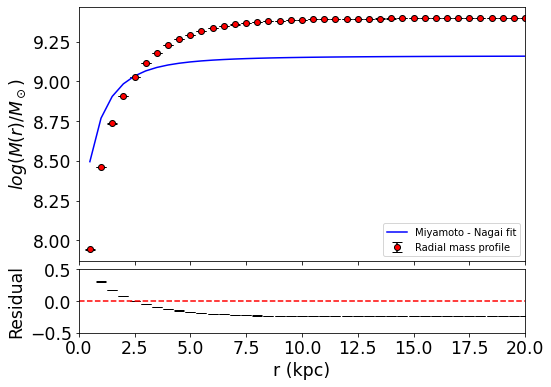

In [16]:
fig = plt.figure(figsize = (8,6))

gs = fig.add_gridspec(2, 1, height_ratios = (4, 1), hspace = 0.05)

ax0 = fig.add_subplot(gs[0, 0])
ax0.errorbar(Rf, np.log10(rad_mass_profile_actual), 
             yerr = rad_mass_profile_actual_error/(rad_mass_profile_actual*np.log(10)),
             ecolor = 'black', capsize = 5, fmt = 'o', color = 'r', markeredgecolor = 'black',
            label = 'Radial mass profile')
ax0.plot(Rf, np.log10(mean_rad_mass_profile_MN), color = 'blue', label = 'Miyamoto - Nagai fit')
#ax0.fill_between(Rf, np.log10(mean_rad_mass_profile_MN - std_rad_mass_profile_MN), 
#                 np.log10(mean_rad_mass_profile_MN + std_rad_mass_profile_MN), 
#                 color = 'cyan', label = '1 sigma band of MN fit')
ax0.set_xlim(0, 20)
ax0.set_xticklabels([])
ax0.set_ylabel(r'$log(M(r)/M_\odot)$')
ax0.legend()

ax1 = fig.add_subplot(gs[1, 0])
ax1.errorbar(Rf, log_radial_res, yerr = log_radial_res_error, ecolor = 'black', capsize = 5, color = 'black'
            , fmt = 'o', markersize = 0)
ax1.set_ylim(-0.5, 0.5)
ax1.hlines(0, 0, 20, color = 'r', linestyles = 'dashed')
ax1.set_xlim(0, 20)
ax1.set_xlabel('r (kpc)')
ax1.set_ylabel('Residual')

plt.savefig('./figures/mass_profile.pdf', bbox_inches = 'tight')

plt.show()